# Microsoft Planetary Computer Sentinel-1 RTC Imagery

This book will demonstrate how to access radiometrically terrain corrected Sentinel-1 imagery from Microsoft Planetary Computer using `stackstac`. STAC stands for spatio-temporal asset catalog, it is a common framework to describe geospatial information and a way for data providers, developers and users to work and communicate efficiently. You can read more about STAC [here](https://stacspec.org/en) and checkout more useful tutorials for working with STAC data.

## Learning goals

**Xarray and python techniques:** <br>
- introduction to working with STAC data
- using `pystac` to query cloud-hosted datasets, observe metadata
- using `stackstac` to read cloud-hosted data as xarray objects
- using `xarray` to manipulate and organize Sentinel-1 SAR data
- performing grouping and reductions on `xarrray` objects
- visualizing `xarray` objects using `FacetGrid`

**High-level science goals:**<br>
- Querying large cloud-hosted dataset
- Accessing cloud-hosted data stored as COGs (cloud-optimized geotiffs)
- Extracting and organizing metadata

In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import rich.table
import planetary_computer
from pystac_client import Client
#import cartopy
from shapely.geometry import Polygon
import rioxarray as rio
import pystac

from IPython.display import Image

We will use the `pystac_client` package to interact with and query the Microsoft Planetary Computer Sentinel-1 RTC dataset. In the cell below, we will create an object called `catalog` by calling the `.open()` method of the `Client` class. This is establishing a connection with the hosted data at the url provided. Explore the catalog object. You 

## STAC items

In [2]:
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1')
catalog

ID: microsoft-pc
Title: Microsoft Planetary Computer STAC API
Description: Searchable spatiotemporal metadata describing Earth science datasets hosted by the Microsoft Planetary Computer
type: Catalog
"conformsTo: ['http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/core', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/geojson', 'http://www.opengis.net/spec/ogcapi-features-1/1.0/conf/oas30', 'https://api.stacspec.org/v1.0.0-rc.1/collections', 'https://api.stacspec.org/v1.0.0-rc.1/core', 'https://api.stacspec.org/v1.0.0-rc.1/item-search', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#fields', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:basic-cql', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-json', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:cql-text', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#filter:item-search-filter', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#query', 'https://api.stacspec.org/v1.0.0-rc.1/item-search#sort', 'https://api.stacspec.org/v1.0.0-rc.1/ogcapi-features']"
ID: daymet-annual-pr
Title: Daymet Annual Puerto Rico
"Description: Annual climate summaries derived from [Daymet](https://daymet.ornl.gov) Version 4 daily data at a 1 km x 1 km spatial resolution for five variables: minimum and maximum temperature, precipitation, vapor pressure, and snow water equivalent. Annual averages are provided for minimum and maximum temperature, vapor pressure, and snow water equivalent, and annual totals are provided for the precipitation variable. [Daymet](https://daymet.ornl.gov/) provides measurements of near-surface meteorological conditions; the main purpose is to provide data estimates where no instrumentation exists. The dataset covers the period from January 1, 1980 to the present. Each year is processed individually at the close of a calendar year. Data are in a Lambert conformal conic projection for North America and are distributed in Zarr and NetCDF formats, compliant with the [Climate and Forecast (CF) metadata conventions (version 1.6)](http://cfconventions.org/). Use the DOI at [https://doi.org/10.3334/ORNLDAAC/1852](https://doi.org/10.3334/ORNLDAAC/1852) to cite your usage of the data. This dataset provides coverage for Hawaii; North America and Puerto Rico are provided in [separate datasets](https://planetarycomputer.microsoft.com/dataset/group/daymet#annual)."
"Providers: Microsoft (host, processor) ORNL DAAC (producer)"
type: Collection
title: Daymet Annual Puerto Rico


Now we will define some parameters to help us query the data catalog for the specific collection, time range and geographic area of interest. 
The function `points2coords()` just helps us to format coordinates for areas of interest.

In [3]:
#we'll use this function to get bounding box coordinates from a list of points 
def points2coords(pt_ls): #should be [xmin, ymin, xmax, ymax]
    
    coords_ls = [(pt_ls[0], pt_ls[1]), (pt_ls[0], pt_ls[3]),
                 (pt_ls[2], pt_ls[3]), (pt_ls[2], pt_ls[1]),
                 (pt_ls[0], pt_ls[1])]
    return coords_ls

In the cell below we specify the time range we're intereste in as well as the geographic area of interest.

In [4]:
time_range = '2021-01-01/2022-08-01'
bbox = [88.214935, 27.92767, 88.302,  28.034]

bbox_coords = points2coords(bbox)
bbox_coords

[(88.214935, 27.92767),
 (88.214935, 28.034),
 (88.302, 28.034),
 (88.302, 27.92767),
 (88.214935, 27.92767)]

Now we will search the catalog for entries that match our criteria for collection (Sentinel-1 RTC), bbox (our AOI) and datetime (our specified time range):

In [5]:
search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox, datetime=time_range)
items = search.get_all_items()
len(items)

100

We've created a few more instances of `pystac_client` classes. Check out the object types below to better familiarize yourself with the pystac package

In [6]:
print(type(catalog))
print(type(search))
print(type(items))

<class 'pystac_client.client.Client'>
<class 'pystac_client.item_search.ItemSearch'>
<class 'pystac.item_collection.ItemCollection'>


You can see that `items` is an instance of the class `ItemCollection`, and we can explore it via the embedded html interface (is that right?)

In [7]:
items

ID: S1A_IW_GRDH_1SDV_20220801T121402_20220801T121427_044359_054B39_rtc
"Bounding Box: [86.20611723, 26.36668589, 88.98467037, 28.28960544]"
Datetime: 2022-08-01 12:14:14.610123+00:00
datetime: 2022-08-01T12:14:14.610123Z
platform: SENTINEL-1A
"s1:shape: [28151, 21598]"
"proj:bbox: [421830.0, 2916390.0, 697320.0, 3130510.0]"
proj:epsg: 32645
"proj:shape: [28151, 21598]"
end_datetime: 2022-08-01 12:14:27.109058+00:00
constellation: Sentinel-1


To make it easier to work with, we can convert  the `items` object to a dictionary, and from there, convert it to a `geopandas.GeoDataFrame`. You can see that the metadata from within each `item` of the `ItemCollection` object is present in the `GeoDataFrame` but its easier to scan and organize this way. 

In [8]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs='epsg:4326')
df.head(5)

,geometry,datetime,platform,s1:shape,proj:bbox,proj:epsg,proj:shape,end_datetime,constellation,s1:resolution,...,sar:center_frequency,sar:resolution_range,s1:product_timeliness,sar:resolution_azimuth,sar:pixel_spacing_range,sar:observation_direction,sar:pixel_spacing_azimuth,sar:looks_equivalent_number,s1:instrument_configuration_ID,sat:platform_international_designator
0,"POLYGON ((86.20612 27.84414, 86.21011 27.78327...",2022-08-01T12:14:14.610123Z,SENTINEL-1A,"[28151, 21598]","[421830.0, 2916390.0, 697320.0, 3130510.0]",32645,"[28151, 21598]",2022-08-01 12:14:27.109058+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A
1,"POLYGON ((89.98012 27.01219, 90.99394 27.17292...",2022-07-27T12:06:06.953202Z,SENTINEL-1A,"[28423, 21970]","[619480.0, 2960660.0, 895840.0, 3178430.0]",32645,"[28423, 21970]",2022-07-27 12:06:19.452211+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A
2,"POLYGON ((89.80442 27.02311, 89.82929 27.27473...",2022-07-23T00:03:32.650978Z,SENTINEL-1A,"[27531, 21084]","[530210.0, 2980900.0, 798705.0, 3190400.0]",32645,"[27531, 21084]",2022-07-23 00:03:45.150333+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A
3,"POLYGON ((86.20591 27.84405, 86.21002 27.78237...",2022-07-20T12:14:13.801000Z,SENTINEL-1A,"[28149, 21598]","[421810.0, 2916380.0, 697280.0, 3130510.0]",32645,"[28149, 21598]",2022-07-20 12:14:26.299940+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A
4,"POLYGON ((89.98022 27.01218, 90.99394 27.17283...",2022-07-15T12:06:06.242032Z,SENTINEL-1A,"[28422, 21971]","[619490.0, 2960670.0, 895840.0, 3178430.0]",32645,"[28422, 21971]",2022-07-15 12:06:18.741751+00:00,Sentinel-1,high,...,5.405,20,Fast-24h,22,10,right,10,4.4,7,2014-016A


In [9]:
df.columns

Index(['geometry', 'datetime', 'platform', 's1:shape', 'proj:bbox',
       'proj:epsg', 'proj:shape', 'end_datetime', 'constellation',
       's1:resolution', 'proj:transform', 's1:datatake_id', 'start_datetime',
       's1:orbit_source', 's1:slice_number', 's1:total_slices',
       'sar:looks_range', 'sat:orbit_state', 'sar:product_type',
       'sar:looks_azimuth', 'sar:polarizations', 'sar:frequency_band',
       'sat:absolute_orbit', 'sat:relative_orbit', 's1:processing_level',
       'sar:instrument_mode', 'sar:center_frequency', 'sar:resolution_range',
       's1:product_timeliness', 'sar:resolution_azimuth',
       'sar:pixel_spacing_range', 'sar:observation_direction',
       'sar:pixel_spacing_azimuth', 'sar:looks_equivalent_number',
       's1:instrument_configuration_ID',
       'sat:platform_international_designator'],
      dtype='object')

Now we want to check out a rendered preview of an individual item from the `ItemCollection` object. We do this by calling the `assets` accessor, and supplying the HREF of the rendered preview key.

In [10]:
Image(url=items[0].assets["rendered_preview"].href)

We can construct a table with metadata for a single scene (ie. a single element of the list `items`)

In [11]:
table = rich.table.Table('key','value')
for k,v in sorted(items[0].properties.items()):
    table.add_row(k, str(v))
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ key                                   ┃ value                                                       ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ constellation                         │ Sentinel-1                                                  │
│ datetime                              │ 2022-08-01T12:14:14.610123Z                                 │
│ end_datetime                          │ 2022-08-01 12:14:27.109058+00:00                            │
│ platform                              │ SENTINEL-1A                                                 │
│ proj:bbox                             │ [421830.0, 2916390.0, 697320.0, 3130510.0]                  │
│ proj:epsg                             │ 32645                                                       │
│ proj:shape                            │ [28151, 21598]                                              │
│ proj:transform                        │ [10.0, 0.0, 421830.0, 0.0, -10.0, 3132220.0, 0.0, 0.0, 1.0] │
│ s1:datatake_id                        │ 346937                                                      │
│ s1:instrument_configuration_ID        │ 7                                                           │
│ s1:orbit_source                       │ RESORB                                                      │
│ s1:processing_level                   │ 1                                                           │
│ s1:product_timeliness                 │ Fast-24h                                                    │
│ s1:resolution                         │ high                                                        │
│ s1:shape                              │ [28151, 21598]                                              │
│ s1:slice_number                       │ 6                                                           │
│ s1:total_slices                       │ 20                                                          │
│ sar:center_frequency                  │ 5.405                                                       │
│ sar:frequency_band                    │ C                                                           │
│ sar:instrument_mode                   │ IW                                                          │
│ sar:looks_azimuth                     │ 1                                                           │
│ sar:looks_equivalent_number           │ 4.4                                                         │
│ sar:looks_range                       │ 5                                                           │
│ sar:observation_direction             │ right                                                       │
│ sar:pixel_spacing_azimuth             │ 10                                                          │
│ sar:pixel_spacing_range               │ 10                                                          │
│ sar:polarizations                     │ ['VV', 'VH']                                                │
│ sar:product_type                      │ GRD                                                         │
│ sar:resolution_azimuth                │ 22                                                          │
│ sar:resolution_range                  │ 20                                                          │
│ sat:absolute_orbit                    │ 44359                                                       │
│ sat:orbit_state                       │ ascending                                                   │
│ sat:platform_international_designator │ 2014-016A                                                   │
│ sat:relative_orbit                    │ 12                                                          │
│ start_datetime                        │ 2022-08-01 12:14:02.111187+00:00                            │
└───────────────────────────────────────┴───────

We can also explore the object metadata outside of the table. Try typing `.assets`, `.links`, `.STAC_extensions` and `.properties` onto the term below. 
You can query the object programmatically for the same metadata stored in the table using dictionary syntax on the `properties` accessor (<-- is that the write word here?).

In [12]:
items[0]
#items[0].assets
#items[0].links

ID: S1A_IW_GRDH_1SDV_20220801T121402_20220801T121427_044359_054B39_rtc
"Bounding Box: [86.20611723, 26.36668589, 88.98467037, 28.28960544]"
Datetime: 2022-08-01 12:14:14.610123+00:00
datetime: 2022-08-01T12:14:14.610123Z
platform: SENTINEL-1A
"s1:shape: [28151, 21598]"
"proj:bbox: [421830.0, 2916390.0, 697320.0, 3130510.0]"
proj:epsg: 32645
"proj:shape: [28151, 21598]"
end_datetime: 2022-08-01 12:14:27.109058+00:00
constellation: Sentinel-1


In [13]:
items[0].properties

{'datetime': '2022-08-01T12:14:14.610123Z',
 'platform': 'SENTINEL-1A',
 's1:shape': [28151, 21598],
 'proj:bbox': [421830.0, 2916390.0, 697320.0, 3130510.0],
 'proj:epsg': 32645,
 'proj:shape': [28151, 21598],
 'end_datetime': '2022-08-01 12:14:27.109058+00:00',
 'constellation': 'Sentinel-1',
 's1:resolution': 'high',
 'proj:transform': [10.0, 0.0, 421830.0, 0.0, -10.0, 3132220.0, 0.0, 0.0, 1.0],
 's1:datatake_id': '346937',
 'start_datetime': '2022-08-01 12:14:02.111187+00:00',
 's1:orbit_source': 'RESORB',
 's1:slice_number': '6',
 's1:total_slices': '20',
 'sar:looks_range': 5,
 'sat:orbit_state': 'ascending',
 'sar:product_type': 'GRD',
 'sar:looks_azimuth': 1,
 'sar:polarizations': ['VV', 'VH'],
 'sar:frequency_band': 'C',
 'sat:absolute_orbit': 44359,
 'sat:relative_orbit': 12,
 's1:processing_level': '1',
 'sar:instrument_mode': 'IW',
 'sar:center_frequency': 5.405,
 'sar:resolution_range': 20,
 's1:product_timeliness': 'Fast-24h',
 'sar:resolution_azimuth': 22,
 'sar:pixel_sp

Now that we'e explored the items that fit our query of the dataset and seen the metadata, let's read the data in using xarray. 

We will now use `dask.distributed` to manage our tasks. Confusingly, we will use the dask.distributed class `Client` to interact with the cluster. 

## Reading data using xarray

In [14]:
from distributed import Client

client = Client(processes=False)
print(client.dashboard_link)

http://192.168.86.35:8787/status


The `client.dashboard_link` points to a dask dashboard for the client we've just instantiated. 

Now that we have queried the data that is available from Microsoft Planetary Computer and inspected the metadata using `pystac`, we will use `stackstac` to read the data into our notebook as an xarray object. Calling `stackstac.stack()` produces a lazy `xarray.DataArray` with dask integration out of a STAC `collection` object. 

In [15]:
type(items)

pystac.item_collection.ItemCollection

In the code cell below, you can see that we pass the object `items`, a `pystac.ItemCollection` to the `stackstac.stack()` method. The wrapper `planetary_computer.sign()` uses Planetary Computer subscription key credentials to access the data. `stackstac` passes the metadata from the STAC collection into the xarray object as coordinates allowing you to further organize and manipulate the object to fit your purposes. `stackstac` can also read the data in according to parameters passed during the `stack()` call. In the code cell below we pass parameters for bounding box and coordinate reference system. To specify the resolution as something other than the resolution at which its stored, pass a `resolution = ` argument. 

In [16]:
import stackstac
import os

da = stackstac.stack(
    planetary_computer.sign(items), bounds_latlon=bbox, epsg=32645
)

In [17]:
da

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,3 Graph Layers,400 Chunks
Type,float64,numpy.ndarray


### Retrieve source granule ID

It will be useful to have the granule ID for the original SAR acquisition and GRD file used to generate the RTC image. The following code demonstrates retrieving the source granule ID from the STAC metadata and adding it as a variable (coorindate?) to the xarray object  containing the RTC imagery.

In [85]:
stac_item = pystac.read_file('https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-1-rtc/items/S1A_IW_GRDH_1SDV_20210602T120544_20210602T120609_038161_0480FD_rtc')

In [86]:
def extract_source_granule_pc(rtc_id):
    
    base_url = 'https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-1-rtc/items/'
    full_url = base_url + str(rtc_id)
    stac_item = pystac.read_file(full_url)
    source_granule = stac_item.links[5].target[-62:]
    return source_granule

In [87]:
granule_ls = [extract_source_granule_pc(da.isel(time=t).id.values) for t in range(len(da.time))]

In [88]:
def make_granule_coord_pc(granule_ls):
    '''this fn takes a list of granule IDs, extracts acq date for each granule, organizes this as an array that can be assigned as a coord to an xr obj'''
        
    acq_date = [pd.to_datetime(granule[17:25]) for granule in granule_ls]

    granule_da = xr.DataArray(data = granule_ls, 
                              dims = ['time'],
                              coords = {'time':acq_date},
                             attrs = {'description': 'source granule ID S1 GRD files used to process PC RTC images, extracted from STAC metadata'},
                             name='granule_id')
    
    return granule_da

In [89]:
granule_coord = make_granule_coord_pc(granule_ls)
granule_coord

<xarray.DataArray 'granule_id' (time: 100)>
array(['S1A_IW_GRDH_1SDV_20210602T120544_20210602T120609_038161_0480FD',
       'S1A_IW_GRDH_1SDV_20210607T121352_20210607T121417_038234_048318',
       'S1A_IW_GRDH_1SDV_20210610T000311_20210610T000336_038270_04841E',
       'S1A_IW_GRDH_1SDV_20210614T120545_20210614T120610_038336_04862F',
       'S1A_IW_GRDH_1SDV_20210619T121353_20210619T121418_038409_04884C',
       'S1A_IW_GRDH_1SDV_20210622T000312_20210622T000337_038445_04895A',
       'S1A_IW_GRDH_1SDV_20210626T120546_20210626T120611_038511_048B6C',
       'S1A_IW_GRDH_1SDV_20210701T121354_20210701T121419_038584_048D87',
       'S1A_IW_GRDH_1SDV_20210704T000312_20210704T000337_038620_048E99',
       'S1A_IW_GRDH_1SDV_20210708T120547_20210708T120612_038686_0490AD',
       'S1A_IW_GRDH_1SDV_20210713T121354_20210713T121419_038759_0492D4',
       'S1A_IW_GRDH_1SDV_20210716T000313_20210716T000338_038795_0493DB',
       'S1A_IW_GRDH_1SDV_20210720T120547_20210720T120612_038861_0495EC',
       'S1A_IW_GRDH_1SDV_20210725T121355_20210725T121420_038934_04980F',
       'S1A_IW_GRDH_1SDV_20210728T000314_20210728T000339_038970_04991E',
       'S1A_IW_GRDH_1SDV_20210801T120548_20210801T120613_039036_049B1F',
       'S1A_IW_GRDH_1SDV_20210806T121356_20210806T121421_039109_049D70',
       'S1A_IW_GRDH_1SDV_20210809T000314_20210809T000339_039145_049EAC',
       'S1A_IW_GRDH_1SDV_20210813T120549_20210813T120614_039211_04A0FF',
       'S1A_IW_GRDH_1SDV_20210818T121356_20210818T121421_039284_04A383',
...
       'S1A_IW_GRDH_1SDV_20220509T121356_20220509T121421_043134_0526C4',
       'S1A_IW_GRDH_1SDV_20220516T120549_20220516T120614_043236_0529DD',
       'S1A_IW_GRDH_1SDV_20220521T121357_20220521T121422_043309_052C00',
       'S1A_IW_GRDH_1SDV_20220528T120550_20220528T120615_043411_052F0A',
       'S1A_IW_GRDH_1SDV_20220602T121358_20220602T121423_043484_053126',
       'S1A_IW_GRDH_1SDV_20220605T000317_20220605T000342_043520_05323C',
       'S1A_IW_GRDH_1SDV_20220609T120551_20220609T120616_043586_053436',
       'S1A_IW_GRDH_1SDV_20220614T121359_20220614T121424_043659_05365F',
       'S1A_IW_GRDH_1SDV_20220617T000317_20220617T000342_043695_053770',
       'S1A_IW_GRDH_1SDV_20220621T120552_20220621T120617_043761_053978',
       'S1A_IW_GRDH_1SDV_20220626T121359_20220626T121424_043834_053BA2',
       'S1A_IW_GRDH_1SDV_20220703T120553_20220703T120618_043936_053EA7',
       'S1A_IW_GRDH_1SDV_20220708T121400_20220708T121425_044009_0540D0',
       'S1A_IW_GRDH_1SDV_20220711T000319_20220711T000344_044045_0541E4',
       'S1A_IW_GRDH_1SDV_20220715T120553_20220715T120618_044111_0543E4',
       'S1A_IW_GRDH_1SDV_20220720T121401_20220720T121426_044184_054615',
       'S1A_IW_GRDH_1SDV_20220723T000320_20220723T000345_044220_05471E',
       'S1A_IW_GRDH_1SDV_20220727T120554_20220727T120619_044286_05491D',
       'S1A_IW_GRDH_1SDV_20220801T121402_20220801T121427_044359_054B39'],
      dtype='<U62')
Coordinates:
  * time     (time) datetime64[ns] 2021-06-02 2021-06-07 ... 2022-08-01
Attributes:
    description:  source granule ID S1 GRD files used to process PC RTC image...

The `granule_coord` object is a 1-dimensional xarray.DataArray containing the source granule IDs for the original GRD files. The values of the `time` coordinate align with the time coordinate of the data object `pc`, allowing us to use the [`xarray.combine_by_coords()`](https://docs.xarray.dev/en/stable/generated/xarray.combine_by_coords.html) function to merge the two into one object.

First, check the dates between the two coordinates are the same (they should be):

In [90]:
for element in range(len(list(da.time)))[:5]:
    print(list(da.time.values)[element])
    print(list(granule_coord.time.values)[element])
    print('')
print(len(da.time))  
print(len(granule_coord.time))

2021-06-02T12:05:57.441074000
2021-06-02T00:00:00.000000000

2021-06-07T12:14:05.058343000
2021-06-07T00:00:00.000000000

2021-06-10T00:03:23.870450000
2021-06-10T00:00:00.000000000

2021-06-14T12:05:58.373830000
2021-06-14T00:00:00.000000000

2021-06-19T12:14:05.865662000
2021-06-19T00:00:00.000000000

100
100


Now, assign granule id as a **non-dimensional coordinate** of the xarray dataset:

In [91]:
da.coords['granule_id'] = ('time',granule_coord.data)

In [92]:
#rename for when we store it to use in the comparison notebook
da_pc = da
da_pc

,Array,Chunk
Bytes,1.54 GiB,6.79 MiB
Shape,"(100, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,3 Graph Layers,400 Chunks
Type,float64,numpy.ndarray


Now we'll store this object to use in a later notebook:

In [93]:
%store da_pc

Stored 'da_pc' (DataArray)


Great, now we have a data cube of Sentinel-1 RTC backscatter imagery with `x`,`y` and `time` dimensions. Take a look at the coordinates and you can see that there is much more information that we can use to query and filter the dataset. 

Let's do a little bit of looking around. We'll define a function to convert the backscatter pixel values from power to dB scale but we won't use it yet. This transformation applies a logarithmic scale to the data which makes visualization easier but we do not want to run any summary statistics on the dB data as it will be distorted.

In [99]:
def power_to_db(input_arr):
    return (10*np.log10(np.abs(input_arr)))

What if we only wanted to look at imagery from the `VV` band? 

In [95]:
da_vv = da.sel(band='vv')

We can do the same for `VH`:

In [96]:
da_vh = da.sel(band='vh')

Next, what if we wanted to look only at imagery taken during `ascending` or `descending` passes of the satellite? `band` is a dimensional coordinate, so we could use xarray's `.sel()` method, but orbital direction is a non-dimensional coordinate so we need to approach it a bit differently: 

In [97]:
da_asc = da.where(da['sat:orbit_state'] == 'ascending', drop=True)
da_desc = da.where(da['sat:orbit_state'] == 'descending', drop=True)
da_asc

,Array,Chunk
Bytes,1.06 GiB,6.79 MiB
Shape,"(69, 2, 1188, 869)","(1, 1, 1024, 869)"
Count,7 Graph Layers,276 Chunks
Type,float64,numpy.ndarray


You can see that there are 69 time steps from the Ascending orbital pass and that all of the same dimensions and coordinates still exist, so you can subset for just the `VV` data from the ascending passes, or other variables you may be itnerested in.

Let's take a look at the two polarizations side-by-side. Below, we'll plot the `VV` and `VH` polarizations from the same date next to each other:

In [1]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))
power_to_db(da_asc.sel(band='vv').isel(time=1)).plot(cmap=plt.cm.Greys_r, ax=axs[0]);
power_to_db(da_asc.sel(band='vv').isel(time=1)).plot(cmap=plt.cm.Greys_r, ax=axs[1]);

NameError: name 'plt' is not defined

It looks like there is some interesting variability between the two images. What if we wanted to see how these differences persist over time?

Let's perform a reduction along the `x` and `y` dimensions so that we can get a better idea of this data over time rather than a snapshot:

In [53]:
da_asc.sel(band='vv').mean(dim=['x','y'])

<xarray.DataArray 'stackstac-ee77a4d9353bffde92de0e4946cef7e1' (time: 69)>
dask.array<mean_agg-aggregate, shape=(69,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates: (12/37)
  * time                                   (time) datetime64[ns] 2021-06-02T1...
    id                                     (time) <U66 'S1A_IW_GRDH_1SDV_2021...
    band                                   <U2 'vv'
    sar:looks_equivalent_number            float64 4.4
    sat:orbit_state                        (time) <U10 'ascending' ... 'ascen...
    sar:product_type                       <U3 'GRD'
    ...                                     ...
    sat:relative_orbit                     (time) int64 114 12 114 ... 12 114 12
    sat:platform_international_designator  <U9 '2014-016A'
    title                                  <U41 'VV: vertical transmit, verti...
    description                            <U173 'Terrain-corrected gamma nau...
    raster:bands                           object {'nodata': -32768, 'data_ty...
    epsg                                   int64 32645

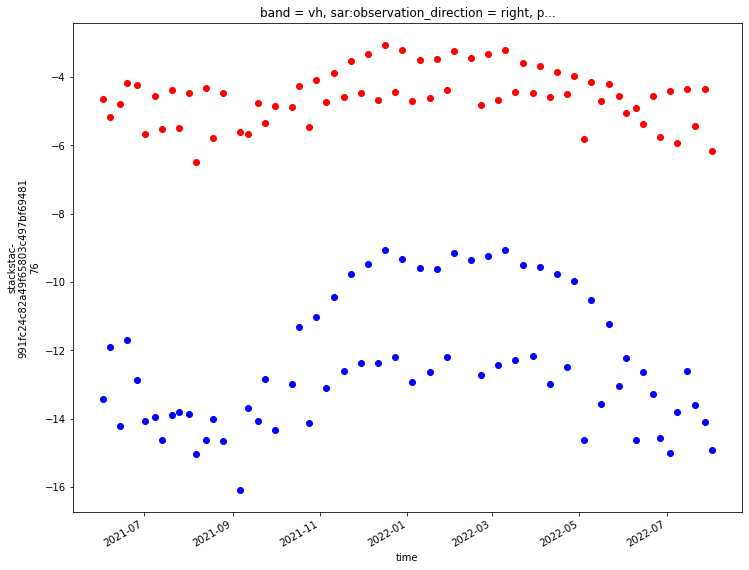

In [101]:
fig, ax = plt.subplots(figsize=(12,9))

ax.set_title('Mean backscatter from ASCENDING passes for VH band (red) and VV band (blue) over time');

power_to_db(da_asc.sel(band='vv').mean(dim=['x','y'])).plot(ax=ax, linestyle='None', marker='o', color='red');
power_to_db(da_asc.sel(band='vh').mean(dim=['x','y'])).plot(ax=ax, linestyle='None', marker='o', color='blue');

```{note}
good idea to link to SAR handbook for interpreting polarizations below or no?
```

Interesting! It looks like there is more variability in the VH band than the VV band. Over the year, there is about 4 dB variability in the VV band but over twice as much in the VH band. Chapter 2 of the [SAR handbook](https://gis1.servirglobal.net/TrainingMaterials/SAR/Chp2Content.pdf) contains information about how polarization impacts radar returns. 
The above plots are looking only at the ascending passes. Let's take a look at all of the time steps (ascending + descending). Any effects based on the different viewing geometries of the ascending and descending passes should have been removed during the radiometric terrain correction step.

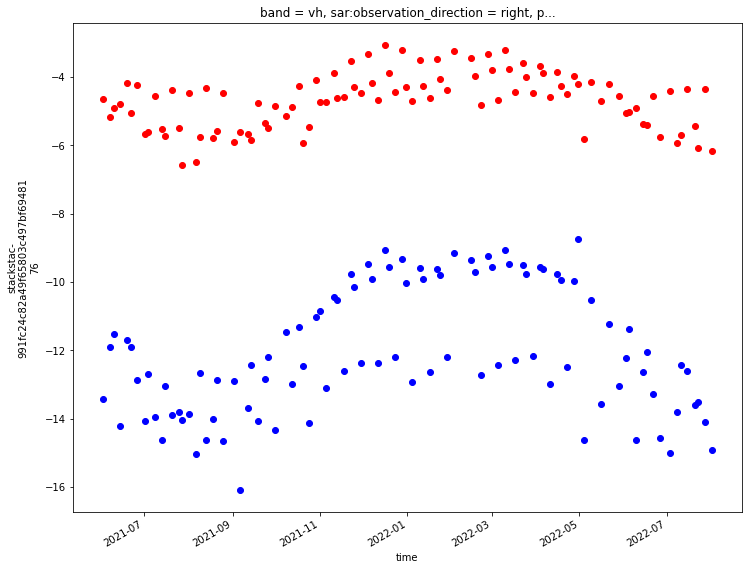

In [104]:
fig, ax = plt.subplots(figsize=(12,9))

ax.set_title('Mean backscatter for VH band (red) and VV band (blue) over time');
power_to_db(da.sel(band='vv').mean(dim=['x','y'])).plot(ax=ax, linestyle='None', marker='o', color='red');
power_to_db(da.sel(band='vh').mean(dim=['x','y'])).plot(ax=ax, linestyle='None', marker='o', color='blue');

Next, let's take a look at how backscatter values vary seasonally. To do this we will use xarray's [groupby()]() and [.facetgrid]() methods.

In [2]:
seasons_gb = da.groupby(da.time.dt.season).mean()
#add the attrs back to the season groupby object
seasons_gb.attrs = da.attrs

NameError: name 'da' is not defined

In [106]:
seasons_gb

<xarray.DataArray 'stackstac-991fc24c82a49f65803c497bf6948176' (season: 4,
                                                                band: 2,
                                                                y: 1188, x: 869)>
dask.array<transpose, shape=(4, 2, 1188, 869), dtype=float64, chunksize=(1, 1, 1024, 869), chunktype=numpy.ndarray>
Coordinates: (12/28)
    sar:observation_direction              <U5 'right'
    platform                               <U11 'SENTINEL-1A'
    proj:epsg                              int64 32645
    sar:center_frequency                   float64 5.405
    sar:looks_range                        int64 5
    sar:resolution_azimuth                 int64 22
    ...                                     ...
  * band                                   (band) <U2 'vh' 'vv'
  * x                                      (x) float64 6.194e+05 ... 6.281e+05
  * y                                      (y) float64 3.102e+06 ... 3.09e+06
    title                                  (band) <U41 'VH: vertical transmit...
    description                            (band) <U173 'Terrain-corrected ga...
  * season                                 (season) object 'DJF' 'JJA' ... 'SON'
Attributes:
    spec:        RasterSpec(epsg=32645, bounds=(619420.0, 3089780.0, 628110.0...
    crs:         epsg:32645
    transform:   | 10.00, 0.00, 619420.00|\n| 0.00,-10.00, 3101660.00|\n| 0.0...
    resolution:  10.0

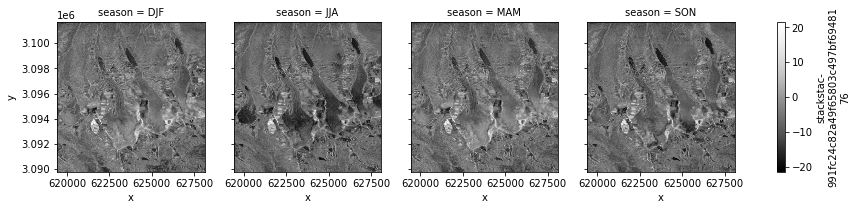

In [108]:
fg_vv = power_to_db(seasons_gb.sel(band='vv')).plot(col='season', cmap=plt.cm.Greys_r);

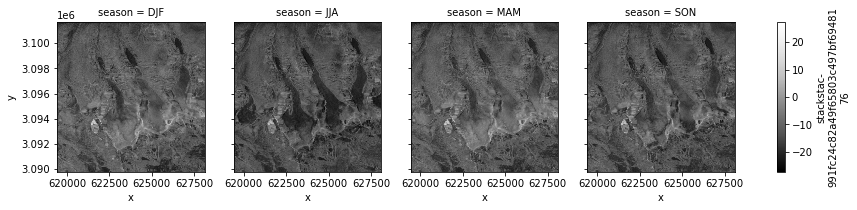

In [109]:
fg_vh = power_to_db(seasons_gb.sel(band='vh')).plot(col='season', cmap=plt.cm.Greys_r);

## Wrap up

This notebook demonstrated how to access cloud-hosted data from Microsoft Planetary Computer, some basic dataset organization and preliminary exploration and visualization. The following notebook will compare the Planetary Computer dataset to the ASF dataset.